# Experiment 1 - Split Connectivity [WIP]

## Details
Observe the effect of selective PN to iKC connectivity on the network's representational power.

Network topology used:
- **Random Sparse**: Neurons are connected randomly with probabilty $p = 0.05$ across the network. Projection weights are $g_{PN,iKC} \in \$

Neuron population sizes are as follows:

\begin{align}
& N_{PN} = \frac{d_{input}}{5}\\
& N_{iKC} = 20 \times N_{PN}\\
& N_{eKC} = N_{class}
\end{align}

where $d_{input}$ is the dimensionality of (flattened) image tensors, and $N_{class}$ is the number of classes.

Each input class contains 20 samples. Prior to spike coding, images are downscaled by a factor of 4. The top 10% most active pixels are calculated across samples within a class and their indices are used to select PN->iKC connectivity in the selective model. Images are encoded into spike times as instantaneous snapshots, with only the top 10% most active pixels per sample used as spikes. $N_{sample}$ images are randomly sampled from the set of inputs, keeping the number of samples from each class balanced. During training, samples are shown to the model within 50ms windows. 

> What would be the effect of adding either 1) Noise from random offsets of encoded spike times or 2) Noise from random spikes not correlated to the input patterns? Would the first facilitate easier learning of good representations? Would the second take away from this?

eKC neuron activity is measured as the spiking rate within a given interval: $\frac{N_{spike}(t)}{50}$, where $50$ is our interval duration, and $t$ indexes the current interval.

> What differences would come about when factoring in the per-interval spiking rate?

To analyse eKC population activity, we calculate:
- Population distance tables (Gaussian distance)


In [1]:
# Add my library
import sys
import os

sys.path.append(os.getcwd() + "/lib")

In [2]:
import numpy as np
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from two_class import get_inputs, run # Experiment script

from lib.util import retrieve_results
from lib.analysis import calculate_activity
from pyNN.utility.plotting import Figure, Panel


Image Dimensions: 27 x 27
Image Vector: 729
Sparsity Ratio per-class: [0.92160494 0.93374486]


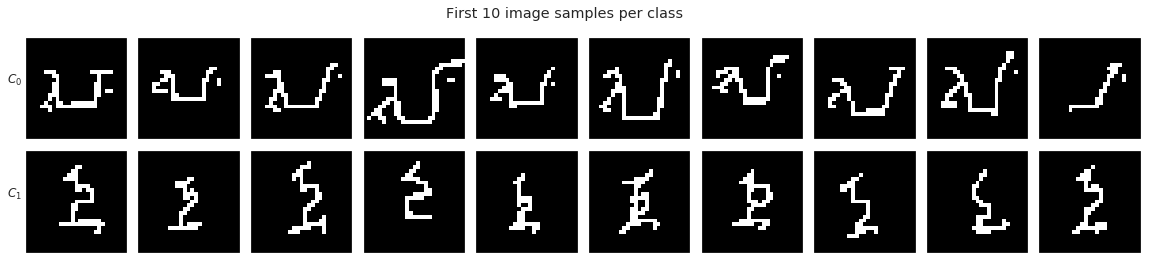

In [3]:
# Fetch inputs and preview examples
N_CLASS = 2
DOWNSCALE = 4

inputs = get_inputs(N_CLASS, DOWNSCALE)
inputs.shape

samples = inputs[:,:10]
w = h = int(np.sqrt(samples.shape[-1]))

print(f"Image Dimensions: {w} x {h}")
print(f"Image Vector: {samples.shape[-1]}")
print(f"Sparsity Ratio per-class: {1-inputs.mean(axis=-1).mean(axis=-1)}")

fig, rows = plt.subplots(N_CLASS, 10, figsize=(20,4))
for i,axes in enumerate(rows):
    for j,(ax,img) in enumerate(zip(axes,samples[i])):
        if j == 0:
            ax.set_ylabel(fr"$C_{i}$".format(i), rotation=0, labelpad=10.0)
        ax.imshow(img.reshape(w,h), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle("First 10 image samples per class")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [4]:
sim_params = run(inputs) # May crash the notebook if weight logging frequency is too high

Setting up
 -- Steps: 1100
 -- n_PN: 729
 -- n_iKC: 14580
 -- n_eKC: 100
Running simulation..

[ ########################################################################### ] 100% 

Done
Saving results to disk...


In [5]:
data = retrieve_results("two_class", version=0)

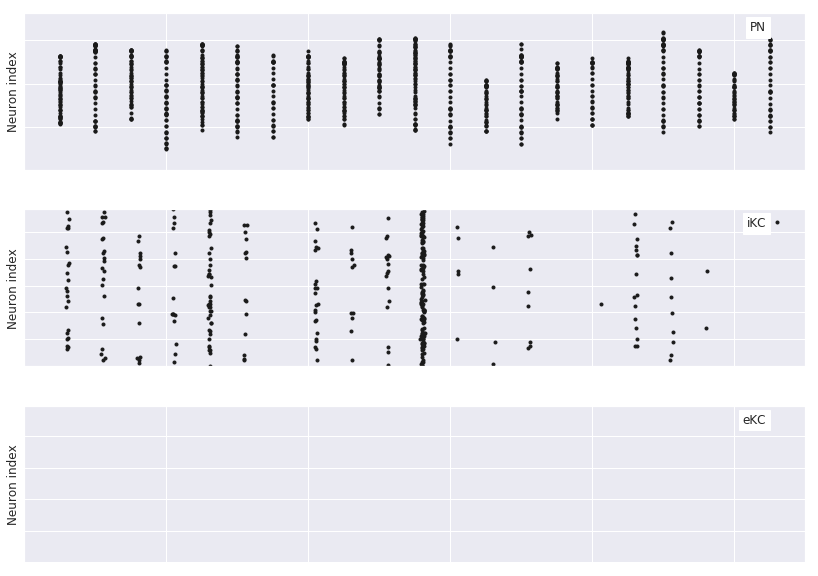

In [6]:
# Plot spikes

Figure(
    Panel(data['PN'].segments[0].spiketrains, data_labels=["PN"]),
    Panel(data['iKC'].segments[0].spiketrains, data_labels=["iKC"]),
    Panel(data['eKC'].segments[0].spiketrains, data_labels=["eKC"]),
    settings={ "font.size": 12 }
)

plt.gcf().set_size_inches(14,10)
plt.show()

## eKC activity

In [7]:
eKC_spiketrains = data['eKC'].segments[0].spiketrains
eKC_activity = calculate_activity(eKC_spiketrains, sim_params['intervals'], sim_params['t_snapshot'])

iKC_spiketrains = data['iKC'].segments[0].spiketrains
iKC_activity = calculate_activity(iKC_spiketrains, sim_params['intervals'], sim_params['t_snapshot'])

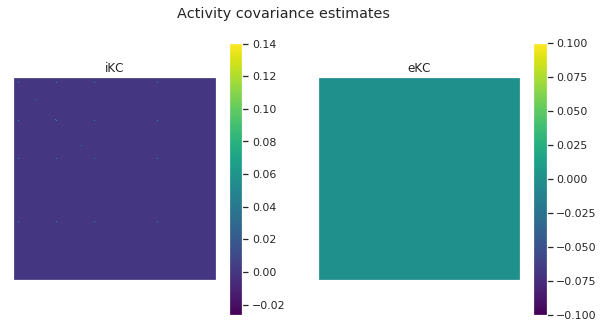

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

for ax,activity in zip(axes, [iKC_activity, eKC_activity]):
    cov = np.cov(activity)
    im  = ax.imshow(cov, cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax)

axes[0].set_title("iKC")
axes[1].set_title("eKC")
fig.suptitle("Activity covariance estimates")

plt.show()

## Weight change

In [9]:
# Changes in weight
weights = np.load("results/two_class_0/weights.npy")
print(weights.shape)
weights = weights.reshape(weights.shape[0], -1) # Don't need spatial information for now
print(weights.shape)

(111, 14580, 100)
(111, 1458000)


In [10]:
mean_weights = np.nanmean(weights, axis=1)

<ipython-input-10-280e56ee0798>:1: RuntimeWarning: Mean of empty slice
  mean_weights = np.nanmean(weights, axis=1)


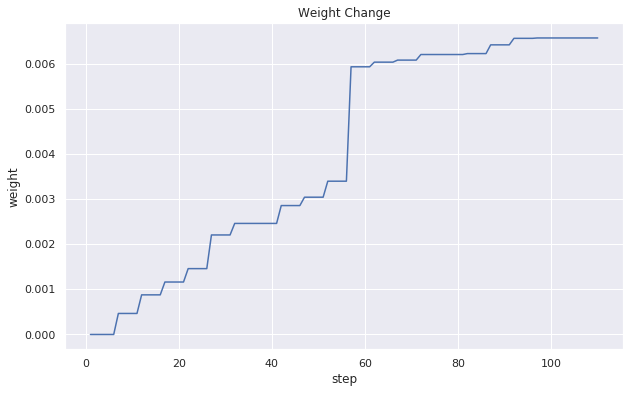

In [11]:
plt.plot(mean_weights)
plt.gcf().set_size_inches(10,6)
plt.title("Weight Change")
plt.xlabel("step")
plt.ylabel("weight")
plt.show()

/home/bikeboi/Research/jra/code/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


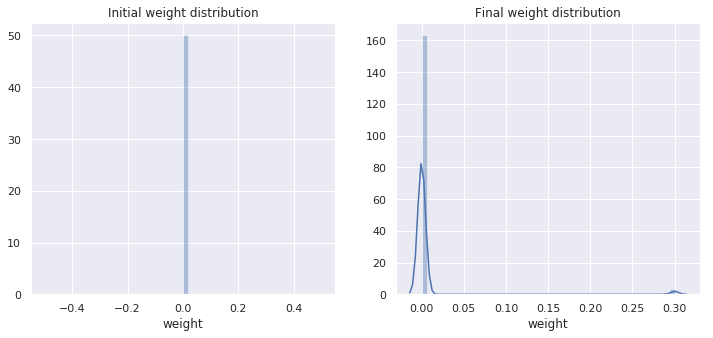

In [12]:
# Changes in distribution
ws = weights[1], weights[-1]
fig, axes = plt.subplots(1,2,figsize=(12,5))

for ax,w in zip(axes,ws):
    ax.set_xlabel("weight")
    sns.distplot(w[~np.isnan(w)], ax=ax, hist_kws={"density": True})

axes[0].set_title("Initial weight distribution")    
axes[1].set_title("Final weight distribution")
axes[1].set_ylabel("")

plt.show()